In [ ]:
from pyspark.sql import SparkSession

from pyspark.sql import functions as f
from pyspark.sql.window import Window

from pyspark.sql.functions import col, when, expr, length, unix_timestamp, hour

from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor, LinearRegression
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, RobustScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import math

# Common evaluators used across cells
evaluator_mae = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="mae")
evaluator_rmse = RegressionEvaluator(labelCol="ArrDelay", predictionCol="prediction", metricName="rmse")


In [ ]:
spark = (SparkSession.builder
         .appName('App')
         .config("spark.driver.memory", "4g")
         .config("spark.executor.memory", "4g")
         .getOrCreate())
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/15 17:07:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
from pyspark.sql.functions import col

def get_data_without_forbidden_variables_sampled(data_path, sample_fraction=0.3):
    data = (spark.read
        .option("header", "true")
        .option("compression", "bzip2")
        .option("inferSchema", True)
        .option("nullValue", "NA")
        .csv(data_path))
    
    forbidden_variables = ['ArrTime', 
                       'ActualElapsedTime', 
                       'AirTime', 
                       'TaxiIn', 
                       'Diverted', 
                       'CarrierDelay', 
                       'WeatherDelay',
                       'NASDelay', 
                       'SecurityDelay', 
                       'LateAircraftDelay']
    
    full_data = data.drop(*forbidden_variables)
    sampled_data = full_data.sample(fraction=sample_fraction, seed=42)
    return sampled_data, full_data

def get_numeric_columns(flights_data): 
    numeric_fields = [column for column in flights_data.columns if ('integer' in str(flights_data.select(column).schema).lower()) and (flights_data.select(column).distinct().count() > 30)]
    return numeric_fields

def get_data_distribution(flights_data):
    numeric_fields = get_numeric_columns(flights_data)
    quantiles={
        fld:[flights_data.where(f.col(fld).isNull()).count()] + 
            [flights_data.corr(fld,'ArrDelay')] + 
            flights_data.approxQuantile(fld, [0.05, 0.25, 0.5, 0.75,0.95], 0) for fld in numeric_fields}
    
    dfq=pd.DataFrame(quantiles)
    dfq['summary']=np.array(['nulls','corr','quantile_05','quantile_25','quantile_50','quantile_75','quantile_95'])
    
    cols = dfq.columns.tolist()
    cols=[cols[-1]]+cols[1:-1]
    finaldf=dfq[cols]
    return finaldf

def get_correlation_matrix_arrival_delay(flights_data):
    numeric_column_names = get_numeric_columns(flights_data)
    data_to_correlate = flights_data.select(numeric_column_names).sample(0.1).toPandas()
    plt.figure()
    corr = data_to_correlate.corr()
    
    ax = sb.heatmap(corr, annot=True)
    plt.title("Correlation matrix for numeric column names", fontsize=20)
    plt.show()
    
def get_numeric_and_categorical_columns(df):
    numeric_column_names = get_numeric_columns(df)
    numeric_column_names = numeric_column_names[1:]
    all_columns = df.columns
    categorical_columns = [col for col in all_columns if col not in numeric_column_names]
    return numeric_column_names, categorical_columns

def get_stacked_bar_for_quantiles(distribution_df_for_plot):
    distribution_df_for_plot = distribution_df_for_plot.drop([0, 1])
    
    # Extracting the selected and other columns
    selected_columns_delay = ['ArrDelay', 'DepDelay']
    selected_columns_dep_delay = ['DepDelay']
    selected_columns_dep_time = ['DepTime', 'CRSDepTime', 'CRSArrTime']
    selected_columns_distance = ['Distance']
    selected_columns_taxi_out = ['TaxiOut']
    
    # Rename the Quantile labels
    quantile_labels = ['Quantile 05', 'Quantile 25', 'Quantile 50', 'Quantile 75', 'Quantile 95']
    
    # Set custom colors for each quantile
    colors = plt.cm.viridis(np.linspace(0, 1, len(quantile_labels)))
    
    # Plotting for 'ArrDelay'
    ax1 = distribution_df_for_plot[selected_columns_delay].transpose().plot(kind='bar', stacked=True, color=colors, figsize=(10, 6))
    ax1.set_ylabel('Quantile Values')
    ax1.set_xlabel('Columns')
    ax1.set_title('Quantile Distribution for Delay')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.legend(quantile_labels, title='Quantiles', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()
    
    # Plotting for 'DepTime', 'CRSDepTime', and 'CRSArrTime'
    ax3 = distribution_df_for_plot[selected_columns_dep_time].transpose().plot(kind='bar', stacked=True, color=colors, figsize=(10, 6))
    ax3.set_ylabel('Quantile Values')
    ax3.set_xlabel('Columns')
    ax3.set_title('Quantile Distribution for DepTime, CRSDepTime, and CRSArrTime')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.legend(quantile_labels, title='Quantiles', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()
    
def get_relevant_categorical_variables(flights_data):
    relevant_categorical_variables = [c for c in flights_data.columns if (flights_data.select(c).distinct().count()<=30) \
                                   and ('Cancelled' not in c) and (flights_data.select(c).distinct().count()>1)]+['ArrDelay']
    return relevant_categorical_variables

def plot_mean_delay_for_relevant_categorical_variables(relevant_categorical_values, data):
    fig = plt.figure(figsize=(15, 12))
    fig.subplots_adjust(hspace=1.1, wspace=0.2)
    p = 1
    
    for fld in relevant_categorical_values[:-1]:
        ax = fig.add_subplot(5, 2, p)
        
        # Aggregate to calculate mean for each group
        gdf = data.groupby(fld).agg(f.mean('ArrDelay').alias('MeanArrDelay'))
        
        # Check condition and plot if necessary
        if gdf.selectExpr('max(MeanArrDelay) / min(MeanArrDelay)').first()[0] > 1.3:
            sb.barplot(x=fld, y='MeanArrDelay', data=gdf.toPandas(), ax=ax)
            plt.xticks(rotation=70)
            p += 1
    
    plt.suptitle('Mean Delay for Categorical variables', fontsize=21)
    plt.show()    
    
def polar_coordinates(column):
    # Calculate angle in radians
    window_spec = Window().rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

    max_value = f.max(column).over(window_spec)
    angle = 2.0 * math.pi * (f.col(column) - 1) / max_value + (math.pi / 2.0)
    
    # Create new columns for polar coordinates
    x_col = f.cos(angle).alias(column + "_polar_x")
    y_col = f.sin(angle).alias(column + "_polar_y")
    
    return x_col, y_col

def transform_cyclical_features_month_week(data):
    cyclical_columns = ["DayofMonth", "Month", "DayOfWeek"]
    transformed_data = data
    for column in cyclical_columns:
        x_col, y_col = polar_coordinates(column)
        transformed_data = transformed_data.withColumn(column + "_polar_x", x_col) \
                                         .withColumn(column + "_polar_y", y_col)
    return transformed_data

def transform_cyclical_features_localtime(data, time_column):
    data = data.filter(col(time_column).isNotNull())

    # Extract hour and minute components
    hours = f.substring(data[time_column], 1, 2).cast("int")
    minutes = f.substring(data[time_column], 3, 2).cast("int")

    # Convert to minutes since midnight
    minutes_since_midnight = f.when((hours.isNotNull()) & (minutes.isNotNull()),
                                    hours * 60 + minutes).otherwise(0)

    # Encode minutes and hours cyclically
    minutes_cosine = f.when(minutes_since_midnight.isNotNull(),
                            f.cos(2.0 * math.pi * minutes_since_midnight / 1440)).otherwise(0).alias(time_column + "_minutes_cosine")
    minutes_sine = f.when(minutes_since_midnight.isNotNull(),
                          f.sin(2.0 * math.pi * minutes_since_midnight / 1440)).otherwise(0).alias(time_column + "_minutes_sine")
    hours_cosine = f.when(hours.isNotNull(),
                          f.cos(2.0 * math.pi * hours / 24)).otherwise(0).alias(time_column + "_hours_cosine")
    hours_sine = f.when(hours.isNotNull(),
                        f.sin(2.0 * math.pi * hours / 24)).otherwise(0).alias(time_column + "_hours_sine")

    # Create new columns with the results
    return data.withColumn(time_column + "_minutes_cosine", minutes_cosine) \
               .withColumn(time_column + "_minutes_sine", minutes_sine) \
               .withColumn(time_column + "_hours_cosine", hours_cosine) \
               .withColumn(time_column + "_hours_sine", hours_sine)

def transform_cyclical_features_localtime_2(data):
    time_columns = ["DepTime", "CRSDepTime", "CRSArrTime"]
    cyclical_data_localtime = data
    for column in time_columns:
        cyclical_data_localtime = transform_cyclical_features_localtime(cyclical_data_localtime, column)
    
    return cyclical_data_localtime

# filter out rows with ArrDelay that are null and flights are known to be cancelled
def clean_data(some_data): 
    some_data_cleaned = some_data.drop("Year", "CancellationCode")#, "TailNum", "TaxiOut")
    some_data_cleaned = some_data_cleaned.filter((f.col("ArrDelay").isNotNull()) & (f.col("Cancelled") == 0))
    some_data_cleaned = some_data_cleaned.filter((f.col("Distance").isNotNull()))
    some_data_cleaned = some_data_cleaned.drop("Cancelled")
    some_data_cleaned = some_data_cleaned.dropDuplicates(["unique_id"])
    return some_data_cleaned

def append_unique_id(some_data):
    some_data_appended = some_data.withColumn(
        "unique_id",
        f.concat_ws("_", "Month", "DayofMonth", "DayOfWeek", "FlightNum", "Origin", "CRSDepTime", "Cancelled")
    )
    return some_data_appended

def get_duplicate_flights(some_data):
    window_spec = Window.partitionBy("unique_id").orderBy("unique_id")
    duplicate_rows = (
        some_data
        .withColumn("row_number", f.row_number().over(window_spec))
        .filter("row_number > 1")
        .drop("row_number")
    )
    return duplicate_rows


def get_percentage_of_flights_without_tailnum(plane_data, original_data):
    flights_tailnums = original_data.select("TailNum").distinct()
    plane_tailnums = plane_data.select("tailnum").distinct()
    missing_tailnums = flights_tailnums.subtract(plane_tailnums)
    missing_tailnums_list = [row.TailNum for row in missing_tailnums.collect()]
    
    flights_data_with_missing = original_data.filter(col("TailNum").isin(missing_tailnums_list))

    total_rows = original_data.count()
    missing_rows = flights_data_with_missing.count()
    percentage_missing = (missing_rows / total_rows) * 100
    
    print(f"Percentage of rows with missing tail numbers: {percentage_missing:.2f}%")

def extend_original_dataset(original_dataset, plane_data_path):
    plane_data = (spark.read
            .option("header", "true")
            .option("inferSchema", True)
            .option("nullValue", "NA")
            .csv(plane_data_path))
    
    columns_to_drop = ["issue_date", "status"]
    plane_data_almost_clean = plane_data.drop(*columns_to_drop)


    threshold_missing_values = 2 # Drop rows with more than 2 missing values
    plane_data_almost_clean = plane_data_almost_clean.na.drop(thresh=(6 - threshold_missing_values))
    
    # just to see the size difference expected
    get_percentage_of_flights_without_tailnum(plane_data_almost_clean, original_dataset)
    
    # need to rename this column to be more specific
    plane_data_almost_clean = plane_data_almost_clean.withColumnRenamed("year", "year_plane")

    # merge datasets on tailnum==TailNum
    flights_data_extended_nonencoded = original_dataset.join(plane_data_almost_clean, original_dataset.TailNum == plane_data_almost_clean.tailnum, "inner")
    flights_data_extended_nonencoded = flights_data_extended_nonencoded.drop("tailnum")
    
    return flights_data_extended_nonencoded

def extract_feature_importance(feature_imp, dataset, features_col): # from Predicting Flight Delay project
    # Extract feature indices and importance scores
    feature_indices = range(len(feature_imp))
    feature_scores = feature_imp.toArray()

    # Create a DataFrame with feature indices and scores
    varlist = pd.DataFrame({'idx': feature_indices, 'score': feature_scores})

    # Merge with metadata to get feature names
    for i in dataset.schema[features_col].metadata["ml_attr"]["attrs"]:
        varlist = pd.merge(varlist, pd.DataFrame(dataset.schema[features_col].metadata["ml_attr"]["attrs"][i]),
                           how='left', left_on='idx', right_on='idx')

    return varlist.sort_values('score', ascending=False)


In [ ]:
# TODO: make it use the argv as input and default to local file if not found
# Use the repo resources path by default; change if you have a different dataset
data_path = "../resources/2007.csv.bz2"  # keep same default; set to your local file if different
sampled_data, full_data = get_data_without_forbidden_variables_sampled(data_path)

In [5]:
numeric_cols, categorical_cols = get_numeric_and_categorical_columns(sampled_data)
print("numeric_cols: ", numeric_cols)
print("categorical_cols: ", categorical_cols)

numeric_cols:  ['DepTime', 'CRSDepTime', 'CRSArrTime', 'FlightNum', 'CRSElapsedTime', 'ArrDelay', 'DepDelay', 'Distance', 'TaxiOut']
categorical_cols:  ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'TailNum', 'Origin', 'Dest', 'Cancelled', 'CancellationCode']


In [ ]:
distribution_df = get_data_distribution(full_data)
distribution_df.head(10)

get_stacked_bar_for_quantiles(distribution_df)

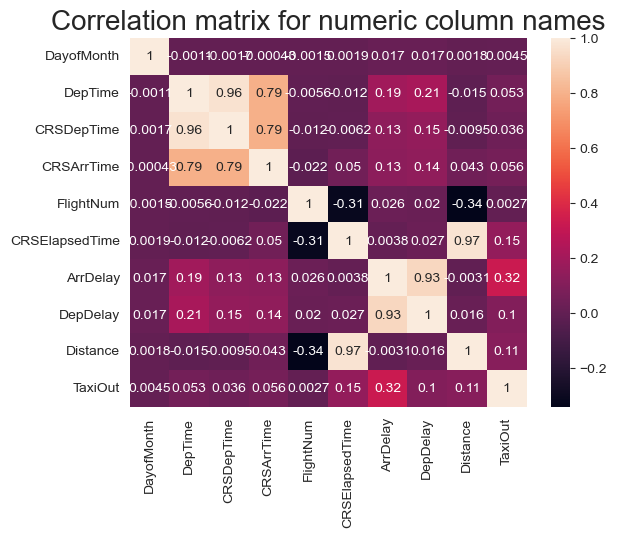

In [7]:
get_correlation_matrix_arrival_delay(full_data)

In [15]:
relevant_categorical_variables = get_relevant_categorical_variables(sampled_data)
plot_mean_delay_for_relevant_categorical_variables(relevant_categorical_variables)

In [ ]:
appended_data = append_unique_id(sampled_data)
duplicate_rows = get_duplicate_flights(appended_data)
# avoid shadowing function names: keep 'cleaned_data' as the variable name
cleaned_data = clean_data(appended_data)

cyclical_data_localtime = transform_cyclical_features_localtime_2(cleaned_data)
cyclical_data = transform_cyclical_features_month_week(cyclical_data_localtime)

In [ ]:
columns_to_check = cleaned_data.columns
null_count_map = {c: cleaned_data.filter(f.col(c).isNull()).count() for c in columns_to_check}
for c, count in null_count_map.items():
    print(f"{c}: {count} null values")
    
original_size = sampled_data.count()
cleaned_size = cleaned_data.count()
size_difference = original_size - cleaned_size
percentage_difference = (size_difference / original_size) * 100

# Print the results
print(f"Original dataset size: {original_size} rows")
print(f"Cleaned dataset size: {cleaned_size} rows")
print(f"Size difference: {size_difference} rows")
print(f"Percentage difference: {percentage_difference:.2f}%")

Month: 0 null values
DayofMonth: 0 null values
DayOfWeek: 0 null values
DepTime: 0 null values
CRSDepTime: 0 null values
CRSArrTime: 0 null values
UniqueCarrier: 0 null values
FlightNum: 0 null values
TailNum: 0 null values
CRSElapsedTime: 0 null values
ArrDelay: 0 null values
DepDelay: 0 null values
Origin: 0 null values
Dest: 0 null values
Distance: 0 null values
TaxiOut: 0 null values
unique_id: 0 null values


Original dataset size: 2237441 rows
Cleaned dataset size: 2183751 rows
Size difference: 53690 rows
Percentage difference: 2.40%


Feature engineering from now onwards

Extend flights_data with plane-data

In [ ]:
plane_data_path = "../src/main/dataset/plane-data.csv" 
flights_data_extended_nonencoded = extend_original_dataset(sampled_data, plane_data_path)

columns_to_explore = ['type', 'manufacturer', 'model', 'status', 'aircraft_type', 'engine_type']

#output_path = "flights_data_extended_nonencoded.csv"
#flights_data_extended_nonencoded.write.csv(output_path, header=True, mode="overwrite")

flights_data_extended_nonencoded.show(5, truncate=False)

Percentage of rows with missing tail numbers: 12.61%


Build model here


In [51]:
def build_decision_tree_model():
    dt = DecisionTreeRegressor(featuresCol='features', labelCol=target_col, maxDepth=5)
    
    dt_model = dt.fit(train_data.select(['features', target_col]))
    predictions_dt = dt_model.transform(validation_data)
    
    evaluator_mae = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="mae")
    evaluator_rmse = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="rmse")
    
    mae_dt = evaluator_mae.evaluate(predictions_dt)
    print(f"Mean Absolute Error (MAE) on validation data (Decision Tree): {mae_dt}")
    rmse_dt = evaluator_rmse.evaluate(predictions_dt)
    print(f"Root Mean Squared Error (RMSE) on validation data (Decision Tree): {rmse_dt}")
    
    feature_table = extract_feature_importance(dt_model.featureImportances, predictions_dt, "features").head(30)
    readable_table = convert_table_to_readable(feature_table)
    readable_table.head(10)
    
    actually_important_features = [feature for feature, score in zip(readable_table['numeric_column'], readable_table['score']) 
                                   if score >= 0.000092 and "_ONEHOT_" not in feature]
    print(actually_important_features)

# this acted as the baseline model
def train_and_evaluate_initial_linear_regression_model(transformed_data):
    target_col = "ArrDelay"

    selected_columns = ["features", "ArrDelay"]
    selected_data = transformed_data.select(selected_columns)
    
    train_ratio = 0.9
    validation_ratio = 1 - train_ratio
    train_data, validation_data = selected_data.sample(0.3, seed=42).randomSplit([train_ratio, validation_ratio], seed=42)
    
    evaluator_mae = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="mae")
    evaluator_rmse = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="rmse")
    
    linearRegression = LinearRegression(featuresCol='features', labelCol=target_col, maxIter=3, regParam=0.01, elasticNetParam=0.5)
    
    lgr_model = linearRegression.fit(train_data.select(['features', target_col]))
    predictions_lgr = lgr_model.transform(validation_data)
    
    mae = evaluator_mae.evaluate(predictions_lgr)
    print(f"Mean Absolute Error (MAE) on validation data (LGR): {mae}")
    
    rmse = evaluator_rmse.evaluate(predictions_lgr)
    print(f"Root Mean Squared Error (RMSE) on validation data (LGR): {rmse}")

def get_initial_pipeline(categorical_columns, numeric_columns):
    stages = []
    # Encode categorical features with StringIndexer and OneHotEncoder
    for feature in categorical_columns:
        indexer = StringIndexer(inputCol=feature, outputCol=feature+'_index')
        indexer.setHandleInvalid("keep")
        
        one_hot_encoder = OneHotEncoder(inputCols=[indexer.getOutputCol()], outputCols=[feature+'_ONEHOT'])
        stages += [indexer, one_hot_encoder]
    
    
    # Scale numerical features with RobustScaler
    percent_assembler = VectorAssembler(inputCols=numeric_columns, outputCol="COMBINED_vec")
    percent_assembler.setHandleInvalid("skip")
    scaler = RobustScaler(inputCol="COMBINED_vec", outputCol="scaledFeatures",
                          withScaling=True, withCentering=False,
                          lower=0.25, upper=0.75)
    stages += [percent_assembler, scaler]
    
    assembler_inputs = [feature + "_ONEHOT" for feature in categorical_columns] + ['scaledFeatures']
    assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
    stages += [assembler]
    
    pipeline = Pipeline(stages=stages)
    return pipeline

def build_initial_linear_regression_model(data):
    data_to_encode = data
    data_to_encode = data_to_encode.drop("unique_id")
    categorical_columns = ["Month", "DayofMonth", "DayOfWeek", "UniqueCarrier", "FlightNum", "TailNum", "Origin", "Dest"]
    numeric_columns = [col for col in data_to_encode.columns if col not in categorical_columns + ["ArrDelay"]]
    combined_features = categorical_columns + numeric_columns
    
    pipeline = get_initial_pipeline(categorical_columns, numeric_columns)
    pipeline_model = pipeline.fit(data_to_encode)
    transformed_data = pipeline_model.transform(data_to_encode)
    train_and_evaluate_initial_linear_regression_model(transformed_data)

In [52]:
data_for_train = cyclical_data 
build_initial_linear_regression_model(data_for_train)

Mean Absolute Error (MAE) on validation data (LGR): 8.652289044185478


Root Mean Squared Error (RMSE) on validation data (LGR): 11.819501145632266


Cross validation and hyperparameter tuning: chose Decision Tree Regressor with max depth = 15 and max bins = 60

In [ ]:
def compute_results(data, evaluators, param_grid, pipeline):
    """Run CrossValidator for each evaluator and return results and best hyperparameters.
    Returns: all_results: [(metric_name, avgMetrics)], best_combinations: [(best_depth, best_bins)]
    """
    all_results = []
    best_combinations = []

    for evaluator in evaluators:
        cross_validator = CrossValidator(estimator=pipeline,
                                         estimatorParamMaps=param_grid,
                                         evaluator=evaluator,
                                         numFolds=3)
        cv_model = cross_validator.fit(data)
        results = list(cv_model.avgMetrics)
        all_results.append((evaluator.getMetricName(), results))

        # try to extract best params if DecisionTree is the final stage
        try:
            best_stage = cv_model.bestModel.stages[-1]
            best_max_depth = best_stage._java_obj.getMaxDepth()
            best_max_bins = best_stage._java_obj.getMaxBins()
            best_combinations.append((best_max_depth, best_max_bins))
        except Exception:
            best_combinations.append((None, None))

    return all_results, best_combinations


def graphs_for_cross_validation(all_results, best_combinations, evaluators, max_depth_values=None, max_bins_values=None):
    # Print the best combinations for each evaluator
    for i, evaluator in enumerate(evaluators):
        metric_name, results = all_results[i]
        best_max_depth, best_max_bins = best_combinations[i]

        print(f"Best combination for {metric_name}:")
        print("  Max Depth:", best_max_depth)
        print("  Max Bins:", best_max_bins)
        print(f"  {metric_name}:", min(results) if results else None)

    # Plot results
    if not all_results or not all_results[0][1]:
        print('No CV results to plot')
        return

    results_arr = np.array(all_results[0][1])

    # if axis values provided, try to use them; else attempt a reasonable grid
    if max_depth_values is None or max_bins_values is None:
        n = results_arr.size
        rows = int(math.floor(math.sqrt(n)))
        cols = int(math.ceil(n / rows))
        padded = np.pad(results_arr, (0, rows * cols - n), constant_values=np.nan)
        grid_results = padded.reshape(rows, cols)
        x_ticks = np.arange(cols)
        y_ticks = np.arange(rows)
    else:
        rows = len(max_depth_values)
        cols = len(max_bins_values)
        try:
            grid_results = results_arr.reshape(rows, cols)
        except Exception:
            # fallback to automatic reshape
            n = results_arr.size
            rows = int(math.floor(math.sqrt(n)))
            cols = int(math.ceil(n / rows))
            padded = np.pad(results_arr, (0, rows * cols - n), constant_values=np.nan)
            grid_results = padded.reshape(rows, cols)
        x_ticks = max_bins_values if max_bins_values is not None else np.arange(grid_results.shape[1])
        y_ticks = max_depth_values if max_depth_values is not None else np.arange(grid_results.shape[0])

    plt.figure(figsize=(8, 6))
    plt.imshow(grid_results, interpolation='nearest', cmap=plt.cm.hot, aspect='auto')
    plt.colorbar()
    plt.xlabel('Max Bins')
    plt.ylabel('Max Depth')
    plt.title('Hyperparameter Tuning Results')
    plt.xticks(np.arange(len(x_ticks)), x_ticks)
    plt.yticks(np.arange(len(y_ticks)), y_ticks)
    plt.show()

In [ ]:
data_for_cross_validation = cyclical_data
# helper that wraps compute_results + graphs_for_cross_validation so the original call works
def find_hyperparameters_using_cross_validation(data):
    # Build a DecisionTree pipeline stage to plug into CrossValidator
    from pyspark.ml.regression import DecisionTreeRegressor
    # placeholder: construct a pipeline that ends with a DecisionTreeRegressor
    # Note: this is a lightweight wrapper — adjust param grid as needed
    dt = DecisionTreeRegressor(labelCol='ArrDelay', featuresCol='features')
    # If a pipeline variable exists in the namespace, reuse it; otherwise build a tiny pipeline
    try:
        base_pipeline = pipeline
    except Exception:
        from pyspark.ml import Pipeline
        base_pipeline = Pipeline(stages=[dt])
    # param grid example
    param_grid = ParamGridBuilder().addGrid(dt.maxDepth, [5, 10, 15]).addGrid(dt.maxBins, [32, 64]).build()
    evaluators = [RegressionEvaluator(labelCol='ArrDelay', predictionCol='prediction', metricName='mae')]
    try:
        all_results, best_combinations = compute_results(data, evaluators, param_grid, base_pipeline)
        graphs_for_cross_validation(all_results, best_combinations, evaluators, max_depth_values=[5,10,15], max_bins_values=[32,64])
    except Exception as e:
        print('Cross-validation failed:', e)

# call the helper (keeps compatibility with previous notebook cell)
find_hyperparameters_using_cross_validation(data_for_cross_validation)

Run the model with the best hyperparameters, taking into account the plane data as well

In [180]:
target_col = "ArrDelay"

important_features_post_dt_testing = ['DepDelay', 'TaxiOut', 'CRSDepTime_minutes_cosine', 'DepTime', 'CRSDepTime', 'CRSDepTime_minutes_sine']
categorical_columns_plane = ['type',
                             'manufacturer',
                             'model',
                             'aircraft_type',
                             'engine_type',
                             'year_plane']

data = flights_data_extended_nonencoded
data = append_unique_id(data)
duplicate_rows = get_duplicate_flights(data)
data = clean_data(data)
data = transform_cyclical_features_localtime_2(data)
data = transform_cyclical_features_month_week(data)
data = data.select(important_features_post_dt_testing + categorical_columns_plane + [target_col])


In [186]:
stages = []

for feature in categorical_columns_plane:
    indexer = StringIndexer(inputCol=feature, outputCol=feature+'_index')
    indexer.setHandleInvalid("keep")
    
    one_hot_encoder = OneHotEncoder(inputCols=[indexer.getOutputCol()], outputCols=[feature+'_ONEHOT'])
    stages += [indexer, one_hot_encoder]

# Scale numerical features
percent_assembler = VectorAssembler(inputCols=important_features_post_dt_testing, outputCol="COMBINED_vec")
percent_assembler.setHandleInvalid("skip")

scaler = RobustScaler(inputCol="COMBINED_vec", outputCol="scaledFeatures",
                      withScaling=True, withCentering=False,
                      lower=0.25, upper=0.75)
stages += [percent_assembler, scaler]

# Feature assembler
assembler_inputs = [feature + "_ONEHOT" for feature in categorical_columns_plane] + ['scaledFeatures']

assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
stages += [assembler]

pipeline = Pipeline(stages=stages)
pipeline_model = pipeline.fit(data)

transformed_data_extended = pipeline_model.transform(data)


In [190]:
train_ratio = 0.9
validation_ratio = 1 - train_ratio
train_data, validation_data = transformed_data_extended.randomSplit([train_ratio, validation_ratio], seed=42)

dt_extended = DecisionTreeRegressor(labelCol=target_col, featuresCol="features", maxDepth=15, maxBins=60, seed=42)

dt_model_extended = dt_extended.fit(train_data.select(['features', target_col]))
predictions_dt_extended = dt_model_extended.transform(validation_data)

mae_dt = evaluator_mae.evaluate(predictions_dt_extended)
print(f"Mean Absolute Error (MAE) on validation data (Decision Tree): {mae_dt}")
rmse_dt = evaluator_rmse.evaluate(predictions_dt_extended)
print(f"Root Mean Squared Error (RMSE) on validation data (Decision Tree): {rmse_dt}")

Mean Absolute Error (MAE) on validation data (Decision Tree): 8.14540863640538


Root Mean Squared Error (RMSE) on validation data (Decision Tree): 12.24988205861919


In [193]:
feature_table = extract_feature_importance(dt_model_extended.featureImportances, predictions_dt_extended, "features").head(30)
readable_table = convert_table_to_readable(feature_table, important_features_post_dt_testing)
readable_table.head(10)

,score,numeric_column
0,0.835842,DepDelay
1,0.059504,DepTime
2,0.056106,TaxiOut
3,0.021177,CRSDepTime
4,0.014706,CRSDepTime_minutes_cosine
5,0.004304,CRSDepTime_minutes_sine
6,0.000850,model_ONEHOT_A320-211
7,0.000759,year_plane_ONEHOT_1992
8,0.000313,model_ONEHOT_E-90
9,0.000306,model_ONEHOT_A320-232


Add new features and test final model on best columns + plane_data columns + new features

In [ ]:
# Create UDF to categorize the time of day
from pyspark.sql.types import StringType

def categorize_time(hour):
    try:
        hour = int(hour)
    except Exception:
        return "unknown"
    morning_interval = [5, 6, 7, 8, 9, 10, 11]
    afternoon_interval = [12, 13, 14, 15, 16, 17, 18]
    evening_interval = [19, 20, 21, 22, 23]
    night_interval = [0, 1, 2, 3, 4]
    
    if hour in morning_interval:
        return "morning"
    elif hour in afternoon_interval:
        return "afternoon"
    elif hour in evening_interval:
        return "evening"
    elif hour in night_interval:
        return "night"
    else:
        return "unknown"

# Feature 1: Flight Time Window: Create a feature that represents the time of day or time window of the flight. You can use DepTime or CRSDepTime to categorize flights into morning, afternoon, evening, etc. 
def add_flight_time_window(data):
    new_features_data = data

    new_features_data = new_features_data.withColumn("DepHour", (col("DepTime") / 100).cast("int"))
    new_features_data = new_features_data.withColumn("CRSDepHour", (col("CRSDepTime") / 100).cast("int"))
    new_features_data = new_features_data.withColumn("CRSArrHour", (col("CRSArrTime") / 100).cast("int"))
    
    categorize_time_udf = f.udf(categorize_time, StringType())
    
    new_features_data = new_features_data.withColumn("DepTime_TOD", categorize_time_udf(col("DepHour")))
    new_features_data = new_features_data.withColumn("CRSDepTime_TOD", categorize_time_udf(col("CRSDepHour")))
    new_features_data = new_features_data.withColumn("CRSArrTime_TOD", categorize_time_udf(col("CRSArrHour")))
    
    columns_to_remove = ['DepHour', 'CRSDepHour', 'CRSArrHour']
    new_features_data = new_features_data.drop(*columns_to_remove)
    return new_features_data

# Feature 2: Day of Week and Weekend Indicator: Combine information from DayOfWeek to create a binary indicator for the weekend. This can be helpful, as weekends might have different patterns of delays compared to weekdays.
def add_weekend_indicator(data):
    new_features_data = data
    new_features_data = new_features_data.withColumn("Weekend", when(col("DayOfWeek").isin([6,7]), "Weekend").otherwise("Weekday"))
    return new_features_data

In [ ]:
target_col = "ArrDelay"

important_features_post_dt_testing = ['DepDelay', 'TaxiOut', 'CRSDepTime_minutes_cosine', 'DepTime', 'CRSDepTime', 'CRSDepTime_minutes_sine']
categorical_columns_plane = ['type', 'manufacturer', 'model', 'aircraft_type', 'engine_type', 'year_plane']
new_features_names = ['DepTime_TOD', 'CRSDepTime_TOD', 'CRSArrTime_TOD', 'Weekend', 'TimeBetweenDepartures']
total_categorical_features = categorical_columns_plane + new_features_names

data = flights_data_extended_nonencoded
data = append_unique_id(data)
data = clean_data(data)
data = transform_cyclical_features_localtime_2(data)
data = transform_cyclical_features_month_week(data)
# add new custom features using defined helpers
data = add_flight_time_window(data)
data = add_weekend_indicator(data)
# TimeBetweenDepartures is optional; compute if FlightNum and CRSDepTime exist
if set(['FlightNum','CRSDepTime']).issubset(set(data.columns)):
    w = Window.partitionBy('FlightNum').orderBy('CRSDepTime')
    data = data.withColumn('prev_CRSDepTime', f.lag('CRSDepTime').over(w))
    data = data.withColumn('TimeBetweenDepartures', (col('CRSDepTime') - col('prev_CRSDepTime')).cast('int'))
# select only columns that are present to avoid KeyError
select_cols = [c for c in (important_features_post_dt_testing + total_categorical_features + [target_col]) if c in data.columns]
data = data.select(*select_cols)

In [227]:
stages = []

for feature in total_categorical_features:
    indexer = StringIndexer(inputCol=feature, outputCol=feature+'_index')
    indexer.setHandleInvalid("keep")
    
    one_hot_encoder = OneHotEncoder(inputCols=[indexer.getOutputCol()], outputCols=[feature+'_ONEHOT'])
    stages += [indexer, one_hot_encoder]

# Scale numerical features
percent_assembler = VectorAssembler(inputCols=important_features_post_dt_testing, outputCol="COMBINED_vec")
percent_assembler.setHandleInvalid("skip")

scaler = RobustScaler(inputCol="COMBINED_vec", outputCol="scaledFeatures",
                      withScaling=True, withCentering=False,
                      lower=0.25, upper=0.75)
stages += [percent_assembler, scaler]

# Feature assembler
assembler_inputs = [feature + "_ONEHOT" for feature in total_categorical_features] + ['scaledFeatures']

assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
stages += [assembler]

pipeline = Pipeline(stages=stages)
pipeline_model = pipeline.fit(data)


In [228]:
transformed_data_extended_new_features = pipeline_model.transform(data)


In [229]:
train_ratio = 0.9
validation_ratio = 1 - train_ratio
train_data, validation_data = transformed_data_extended_new_features.randomSplit([train_ratio, validation_ratio], seed=42)

dt_extended_extended_new_features = DecisionTreeRegressor(labelCol=target_col, featuresCol="features", maxDepth=15, maxBins=60, seed=42)

dt_model_extended_extended_new_features = dt_extended_extended_new_features.fit(train_data.select(['features', target_col]))
predictions_dt_extended_extended_new_features = dt_model_extended_extended_new_features.transform(validation_data)

mae_dt = evaluator_mae.evaluate(predictions_dt_extended_extended_new_features)
print(f"Mean Absolute Error (MAE) on validation data (Decision Tree): {mae_dt}")
rmse_dt = evaluator_rmse.evaluate(predictions_dt_extended_extended_new_features)
print(f"Root Mean Squared Error (RMSE) on validation data (Decision Tree): {rmse_dt}")

Mean Absolute Error (MAE) on validation data (Decision Tree): 8.078325131386253


Root Mean Squared Error (RMSE) on validation data (Decision Tree): 12.871386494240152


In [230]:
feature_table = extract_feature_importance(dt_model_extended_extended_new_features.featureImportances, predictions_dt_extended_extended_new_features, "features").head(30)
readable_table = convert_table_to_readable(feature_table, important_features_post_dt_testing)
readable_table.head(10)

,score,numeric_column
0,0.833913,DepDelay
1,0.055884,TaxiOut
2,0.050666,DepTime
3,0.015193,CRSDepTime
4,0.010954,CRSDepTime_TOD_ONEHOT_afternoon
5,0.006975,CRSDepTime_minutes_cosine
6,0.005527,DepTime_TOD_ONEHOT_morning
7,0.004922,CRSDepTime_minutes_sine
8,0.002154,CRSArrTime_TOD_ONEHOT_afternoon
9,0.001547,model_ONEHOT_A320-211


In [ ]:
spark.stop()


'DepTime', 'CRSDepTime', 'CRSElapsedTime', 'DepDelay', 'Distance','TaxiOut' are good for Linear Regression (allegedly)


Label accuracy: 0.9167 (rows=12)
Confusion matrix (counts):


predicted_label,delayed,early
actual_label,,
delayed,10,0
early,0,1
on time,0,1


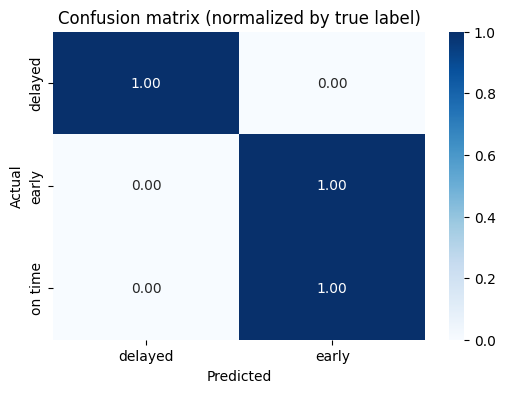

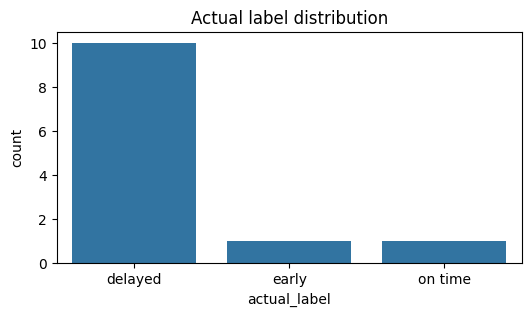

Number of mismatches: 1


,DepDelay,TaxiOut,CRSDepTime_minutes_cosine,DepTime,CRSDepTime,CRSDepTime_minutes_sine,type,manufacturer,model,aircraft_type,...,engine_type_index,year_plane_index,DepTime_TOD_index,CRSDepTime_TOD_index,CRSArrTime_TOD_index,Weekend_index,TimeBetweenDepartures_index,prediction,predicted_label,actual_label
5,-13,1,-0.117537,1733,1733,-0.993068,Corporation,BOEING,737-3H4,Fixed Wing Multi-Engine,...,0.0,11.0,0.0,0.0,3.0,1.0,0.0,-12.421053,early,on time


In [1]:
# This cell loads the model output CSVs produced by the training script (output_full_t10)
# and computes simple label-level metrics and plots so the notebook can be run without retraining.
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pred_path = os.path.join('..', 'output_full_t10', 'predictions.csv')
test_pred_path = os.path.join('..', 'output_full_t10', 'test_predictions.csv')

def load_predictions(path):
    if not os.path.exists(path):
        print(f'Missing file: {path} — run the training script to produce it.')
        return None
    df = pd.read_csv(path)
    # Normalize column names (trim spaces)
    df.columns = [c.strip() for c in df.columns]
    return df

preds = load_predictions(pred_path)
test_preds = load_predictions(test_pred_path)

# Prefer showing test set metrics if available, otherwise show training predictions
df_to_use = test_preds if test_preds is not None else preds
if df_to_use is None:
    print('No prediction CSVs found. Please run the training script (src/main/main.py) to generate outputs in output_full_t10/ or update the path.')
else:
    expected_cols = ['predicted_label', 'actual_label']
    missing = [c for c in expected_cols if c not in df_to_use.columns]
    if missing:
        print('The prediction CSV is missing expected columns:', missing)
    else:
        df = df_to_use.copy()
        df['predicted_label'] = df['predicted_label'].astype(str)
        df['actual_label'] = df['actual_label'].astype(str)

        # Simple accuracy
        acc = (df['predicted_label'] == df['actual_label']).mean()
        print(f'Label accuracy: {acc:.4f} (rows={len(df)})')

        # Confusion matrix (counts)
        cm_counts = pd.crosstab(df['actual_label'], df['predicted_label'], dropna=False)
        print('Confusion matrix (counts):')
        display(cm_counts)

        # Normalized per-true-class (rows sum to 1)
        cm_norm = pd.crosstab(df['actual_label'], df['predicted_label'], normalize='index').fillna(0)

        plt.figure(figsize=(6,4))
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
        plt.title('Confusion matrix (normalized by true label)')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

        # Label distribution
        plt.figure(figsize=(6,3))
        order = sorted(df['actual_label'].unique())
        sns.countplot(x='actual_label', data=df, order=order)
        plt.title('Actual label distribution')
        plt.show()

        # Show some mismatches for inspection
        mismatches = df[df['predicted_label'] != df['actual_label']]
        print(f'Number of mismatches: {len(mismatches)}')
        if len(mismatches) > 0:
            display(mismatches.head(10))

        # Example: show a few example rows where prediction was 'delayed' but actual was 'on time' (if present)
        if {'delayed','on time','early'}.issubset(set(df['predicted_label'].unique()).union(set(df['actual_label'].unique()))):
            example = df[(df['predicted_label']=='delayed') & (df['actual_label']=='on time')]
            if len(example)>0:
                print('Example rows: predicted=delayed but actual=on time (showing up to 5)')
                display(example.head(5))
